In [1]:
!apt-get install swig
!pip install smac[all]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-drivers cuda-license-10-2 cuda-npp-10-1
  cuda-npp-dev-10-1 cuda-nsight-10-1 cuda-nsight-compute-10-1
  cuda-nsight-systems-10-1 cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1
  cuda-nvjpeg-10-1 cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1
  cuda-nvvp-10-1 default-jre dkms freeglut3 freeglut3-dev
  keyboard-configuration libargon2-0 libcap2 libcryptsetup12 libcublas10
  libdevmapper1.02.1 libfontenc1 libgtk2.0-0 libgtk2.0-common libidn11
  libip4tc0 libjansson4 libnvidia-cfg1-440 libnvidia-common-430
  libnvidia-common-440 libnvidia-decode-440 libnvidia-encode-440
  libnvidia-fbc1-440 libnvidia-gl-440 libnvidia-ifr1-440 libpam-systemd
  libpo

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO


from smac.optimizer.acquisition import LCB, EI, PI
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.runhistory.runhistory2epm import RunHistory2EPM4InvScaledCost

from numpy import genfromtxt
import logging

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import random

In [0]:
data_fertility = genfromtxt('php9pgo5r.csv', delimiter=',', skip_header = 1)
data = data_fertility[:,:-1]
target = data_fertility[:,-1]

In [5]:
cs = ConfigurationSpace()
learning_rate = UniformFloatHyperparameter("learning_rate_init", 0.01, 1.0)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9)
cs.add_hyperparameters([learning_rate,momentum])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 1.0], Default: 0.505,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5]

In [0]:
def ann_from_cfg(cfg):

  random_seed =int(cfg['momentum']*cfg['learning_rate_init']*5000)
  
  clf = MLPClassifier(**cfg, hidden_layer_sizes = (4,2,), random_state=random_seed)
  scores = cross_val_score(clf, data, target, cv=StratifiedKFold(n_splits=10,random_state=strat_seed), scoring="accuracy")
  return -np.mean(scores)

In [7]:
# Scenario object
scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternatively runtime)
                     "runcount-limit": 25,   # max. number of function evaluations; for this example set to a low number
                     "cs": cs,               # configuration space
                     "deterministic": "true",
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-12-09_10:15:11_259139


In [0]:
init = cs.sample_configuration(5)
strat_seed=12345

In [25]:
print("Optimizing using EI acquisition function:\n")

smac_EI_acq_func=SMAC4BO(scenario = scenario,
                tae_runner = ann_from_cfg,
               initial_design = None,
              initial_design_kwargs = {'max_config_fracs': 5/25},
               initial_configurations = init,
               acquisition_function = EI)

incumbent_EI_acq_func = smac_EI_acq_func.optimize()

inc_value_EI_acq_func = ann_from_cfg(incumbent_EI_acq_func)
print("Optimized Value: %.2f" % (-inc_value_EI_acq_func))

INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Optimizing using EI acquisition function:



INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensifi

Optimized Value: 0.89


In [26]:
print("Optimizing using LCB acquisition function:\n")

smac_LCB_acq_func=SMAC4BO(scenario = scenario,
                tae_runner = ann_from_cfg,
               initial_design = None,
              initial_design_kwargs = {'max_config_fracs': 5/25},
               initial_configurations = init,
               acquisition_function = LCB)

incumbent_LCB_acq_func = smac_LCB_acq_func.optimize()

inc_value_LCB_acq_func = ann_from_cfg(incumbent_LCB_acq_func)
print("Optimized Value: %.2f" % (-inc_value_LCB_acq_func))

INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Optimizing using LCB acquisition function:



INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensifi

Optimized Value: 0.88


In [0]:
def get_acquisition_function_history(smac):

  maximum = 0.00000001
  history_of_maximums = []

  history = -smac.get_X_y()[1]

  for i in range(len(history)):
      if history[i] > maximum:
          maximum = history[i]
          history_of_maximums.append(maximum)
      else:
          history_of_maximums.append(maximum) 
  
  return history_of_maximums

In [0]:
history_EI = get_acquisition_function_history(smac_EI_acq_func)
history_LCB = get_acquisition_function_history(smac_LCB_acq_func)

Text(0, 0.5, 'Accuracy')

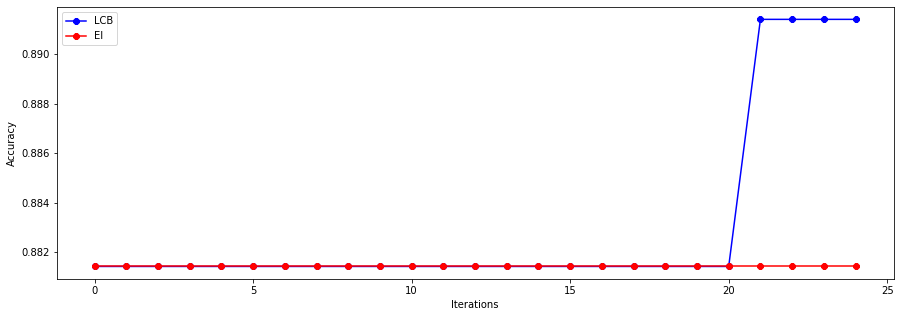

In [29]:
plt.figure(figsize = (15,5))
plt.plot(history_EI, marker = "8", color = "blue")
plt.plot(history_LCB, marker = "8",color="red")
plt.legend(["LCB", "EI"])
plt.xlabel("Iterations")
plt.ylabel("Accuracy")


In [14]:
mlp = MLPClassifier(hidden_layer_sizes = (4,2,))
mlp_param_grid = {"learning_rate_init":[0.01, 0.03, 0.06, 0.09, 0.1], "momentum":[0.1, 0.2, 0.4, 0.6, 0.9]}

mlp_grid = GridSearchCV(mlp, mlp_param_grid, scoring = "accuracy", cv = StratifiedKFold(n_splits=10,random_state=strat_seed))

mlp_grid.fit(data, target)

print("Best params: {}\nBest score: {}".format(mlp_grid.best_params_, mlp_grid.best_score_))


Best params: {'learning_rate_init': 0.01, 'momentum': 0.1}
Best score: 0.88


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
param_distribution = {"learning_rate_init":uniform(0.01, 0.1), "momentum":uniform(0.1, 0.9)}

mlp_random = RandomizedSearchCV(mlp, param_distribution, scoring = "accuracy", cv = StratifiedKFold(n_splits=10,random_state=strat_seed) , n_iter = 25)

mlp_random.fit(data, target)

print("Best params: {}\nBest score: {}".format(mlp_random.best_params_, mlp_random.best_score_))

Best params: {'learning_rate_init': 0.05431456317397255, 'momentum': 0.14092100882739633}
Best score: 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
##### STEP 2

In [17]:
cs_2 = ConfigurationSpace()
learning_rate_2 = UniformFloatHyperparameter("learning_rate_init_2", 0.01, 1.0)
momentum_2 = UniformFloatHyperparameter("momentum_2", 0.1, 0.9)
hidden_neurons_1 = UniformIntegerHyperparameter("hidden_neurons_1", 1, 5)
hidden_neurons_2 = UniformIntegerHyperparameter("hidden_neurons_2", 1, 5)

cs_2.add_hyperparameters([learning_rate_2,momentum_2,hidden_neurons_1,hidden_neurons_2])

[learning_rate_init_2, Type: UniformFloat, Range: [0.01, 1.0], Default: 0.505,
 momentum_2, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5,
 hidden_neurons_1, Type: UniformInteger, Range: [1, 5], Default: 3,
 hidden_neurons_2, Type: UniformInteger, Range: [1, 5], Default: 3]

In [0]:
def ann_from_cfg_2(cfg):

  random_seed_2 = int(cfg["learning_rate_init_2"]*cfg["momentum_2"]*5000)

  clf = MLPClassifier(learning_rate_init = cfg["learning_rate_init_2"],
                      momentum = cfg["momentum_2"], 
                      hidden_layer_sizes = (cfg["hidden_neurons_1"],cfg["hidden_neurons_2"],),
                      random_state = random_seed_2)

  scores_2 = cross_val_score(clf, data, target, cv =StratifiedKFold(n_splits=10,random_state=strat_seed), scoring = 'accuracy')


  return -np.mean(scores_2)

In [0]:
init_2 = cs_2.sample_configuration(10)

In [20]:
# Scenario object
scenario_2 = Scenario({"run_obj": "quality",   # we optimize quality (alternatively runtime)
                     "runcount-limit": 110,   # max. number of function evaluations; for this example set to a low number
                     "cs": cs_2,               # configuration space
                     "deterministic": "true",
                     "abort_on_first_run_crash": "false"
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-12-09_10:18:46_044069


In [21]:
print("Optimizing using EI acquisition function:\n")

smac_EI_acq_func_2=SMAC4HPO(scenario = scenario_2,
                tae_runner = ann_from_cfg_2,
               initial_design = None,
              initial_design_kwargs = {'max_config_fracs': 10/110},
               initial_configurations = init_2,
               acquisition_function = EI)

incumbent_EI_acq_func_2 = smac_EI_acq_func_2.optimize()

inc_value_EI_acq_func_2 = ann_from_cfg_2(incumbent_EI_acq_func_2)
print("Optimized Value: %.2f" % (-inc_value_EI_acq_func_2))

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Optimizing using EI acquisition function:



INFO:smac.intensification.intensification.Intensifier:Challenger (-0.8814) is better than incumbent (-0.8714) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  hidden_neurons_1 : 3 -> 1
INFO:smac.intensification.intensification.Intensifier:  hidden_neurons_2 : 4 -> 1
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init_2 : 0.9909430032430783 -> 0.545279802949211
INFO:smac.intensification.intensification.Intensifier:  momentum_2 : 0.6299723146582347 -> 0.7999628865153477
INFO:smac.intensification.intensification.Intensifier:Challenger (-0.9005) is better than incumbent (-0.8814) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  hidden_neurons_1 : 1 -> 4
INFO:smac.intensification.intensification.Intensifier:  hidden_neurons_2 : 1 -> 5
INFO:smac.intensification.intensification.Intensi

Optimized Value: 0.90


In [22]:
print("Optimizing using LCB acquisition function:\n")

smac_LCB_acq_func_2=SMAC4HPO(scenario = scenario_2,
                tae_runner = ann_from_cfg_2,
               initial_design = None,
              initial_design_kwargs = {'max_config_fracs': 10/110},
               initial_configurations = init_2,
               acquisition_function = LCB)

incumbent_LCB_acq_func_2 = smac_LCB_acq_func_2.optimize()

inc_value_LCB_acq_func_2 = ann_from_cfg_2(incumbent_LCB_acq_func_2)
print("Optimized Value: %.2f" % (-inc_value_LCB_acq_func_2))

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Optimizing using LCB acquisition function:



INFO:smac.intensification.intensification.Intensifier:Challenger (-0.8814) is better than incumbent (-0.8714) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  hidden_neurons_1 : 3 -> 1
INFO:smac.intensification.intensification.Intensifier:  hidden_neurons_2 : 4 -> 1
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init_2 : 0.9909430032430783 -> 0.545279802949211
INFO:smac.intensification.intensification.Intensifier:  momentum_2 : 0.6299723146582347 -> 0.7999628865153477
INFO:smac.intensification.intensification.Intensifier:Challenger (-0.9005) is better than incumbent (-0.8814) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  hidden_neurons_1 : 1 -> 4
INFO:smac.intensification.intensification.Intensifier:  hidden_neurons_2 : 1 -> 5
INFO:smac.intensification.intensification.Intensi

Optimized Value: 0.90


In [0]:
history_EI_2 = get_acquisition_function_history(smac_EI_acq_func_2)
history_LCB_2 = get_acquisition_function_history(smac_LCB_acq_func_2)

Text(0, 0.5, 'Accuracy')

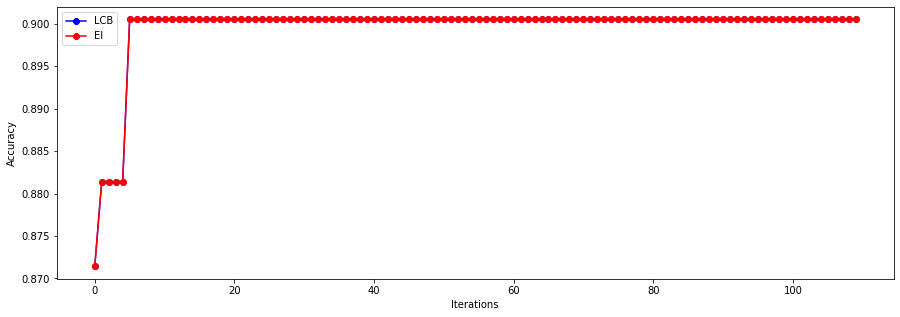

In [24]:
plt.figure(figsize = (15,5))
plt.plot(history_EI_2, marker = "8", color = "blue")
plt.plot(history_LCB_2, marker = "8",color="red")
plt.legend(["LCB", "EI"])
plt.xlabel("Iterations")
plt.ylabel("Accuracy")